In [1]:
import multiprocess
import OverlapDevelopmentMP
import time
import ipypb # Lightweight progress bar, source copied from GitHub
import geopandas

DIR_DATA = 'Data/'

In [2]:
def GMLtoGDF(filename):
    gdf = geopandas.read_file(filename)
    gdf = gdf.set_crs(epsg=3347) # Needed only for FSA file, the others are 3347 and parsed correctly by geopandas, and the pdf in the zip file has the same projection parameters (FSA vs. DA, ADA, CT)
    gdf['Area'] = gdf.geometry.to_crs(epsg=6931).area # Equal-area projection # MODIFY THIS to account for validity regions of each geometry
    gdf['Centroid'] = gdf.geometry.centroid
    gdf['Centroid'] = gdf['Centroid'].to_crs(epsg=4326) # Only the set geometry is converted with gdf.to_crs(); all other geometry-containing columns must be converted explicitly; here we convert all columns explicitly
    gdf['Centroid Latitude'] = gdf['Centroid'].geometry.y
    gdf['Centroid Longitude'] = gdf['Centroid'].geometry.x
    gdf.drop(columns = 'Centroid', inplace=True) # Because WKT Point cannot be serialized to JSON, we drop the Centroid column and keep only its float components
    return gdf

In [3]:
def extendBound(bound,direction='up',method='nearestLeadingDigit',scale=10):
    '''Extend bound to next 'round' number
    
    Parameters
    ----------
    bound: float or float castable number or a list thereof
    direction: {'up','down',nonzero number} or a list of these values indicating the direction to round in
    method: str describing the extension method
        'nearestLeadingDigit': Bound is nearest numbers with leading digit followed by zeros
        'nearestPower': Bound is nearest integer power of scale (scale must be > 1).  For negative numbers, the sign and direction are reversed, the extension performed, then the sign of the result is reversed back.
        'nearestMultiple': Bound is nearest multiple of scale (scale must be > 0)
        'round': Bound is rounded using the default method
    scale: numeric as described in method options or a list thereof
    
    Returns
    -------
    float: the extended bound
    
    Notes
    -----
    All inputs, if not single-valued, must be list-castable and of equal length
    If all inputs are single-valued, the output is a float, otherwise it is a list of floats
    '''
    import numpy as np
    
    # Check and adjust the length of inputs
    unlist = False
    try:
        bound = list(bound)
    except:
        try:
            bound = [bound]
            unlist = True
        except:
            print("Input 'bound' must be numeric or convertible to list type.")
            return None
    try:
        if type(direction)==str:
            direction = [direction]
        direction = list(direction)
    except:
        try:
            direction = [direction]
        except:
            print("Input 'direction' must be a string or nonzero number or convertible to list type.")
            return None
    try:
        if type(method)==str:
            method = [method]
        method = list(method)
    except:
        try:
            method = [method]
        except:
            print("Input 'method' must be a string or convertible to list type.")
            return None
    try:
        scale = list(scale)
    except:
        try:
            scale = [scale]
        except:
            print("Input 'scale' must be numeric or convertible to list type.")
            return None
    inputs = [bound, direction, method, scale]
    lengths = [len(i) for i in inputs]
    set_lengths = set(lengths)
    max_len = max(set_lengths)
    set_lengths.remove(1)
    if len(set_lengths)>1:
        print('Inputs must be of the same length or of length one.  See help(extendBound)')
        return None
    if max_len>1: # can this be converted to a looped statement?
        if len(bound)==1:
            bound = bound*max_len
        if len(direction)==1:
            direction = direction*max_len
        if len(method)==1:
            method = method*max_len
        if len(scale)==1:
            scale = scale*max_len
        unlist = False

    # If multiple methods are specified, recursively call this function for each method and reassemble results
    if len(bound)>1 and len(set(method))>1:
        ret = np.array([None for b in bound])
        for m in list(set(method)):
            ind = np.where(np.array(method)==m)
            ret[ind] = extendBound(list(np.array(bound)[ind]),list(np.array(direction)[ind]),m,list(np.array(scale)[ind]))
        return list(ret)
    
    # Convert direction to a logical array roundup
    try:
        roundup = [True if d=='up' else False if d=='down' else True if float(d)>0 else False if float(d)<0 else None for d in direction]
    except:
        print('direction must be "up", "down", or a non-negative number')
        return None
    if any([r==None for r in roundup]):
        print('direction must be "up", "down", or a non-negative number')
        return None
    
    # Cases for multiple methods handled above, return to string method
    method = method[0]
    
    # Execute the conversions
    if method=='nearestLeadingDigit':
        iszero = np.array(bound)==0
        isnegative = np.array(bound) < 0
        offsets = np.logical_xor(roundup, isnegative)
        power = [0 if z else np.floor(np.log10(abs(b))) for b, z in zip(bound, iszero)]
        firstdigit = [abs(b)//np.power(10,p) for b, p in zip(bound, power)]
        exceeds = [abs(b)>f*np.power(10,p) for b, f, p in zip(bound, firstdigit, power)]
        newbound = [abs(b) if not t else (f+o)*np.power(10,p) for b, t, n, f, o, p in zip(bound, exceeds, isnegative, firstdigit, offsets, power)]
        newbound = [-n if t else n for n, t in zip(newbound,isnegative)]
    elif method=='nearestPower':
        try:
            scale = [float(s) for s in scale]
            if any([s<=1 for s in scale]):
                print('scale should be greater than 1')
                return None
        except ValueError:
            print('scale should be a number or list of numbers greater than 1')
            return None
        isnegative = np.array(bound) < 0
        offsets = np.logical_xor(roundup, isnegative)
        roundfuns = [np.ceil if o else np.floor for o in offsets]
        newbound = [0 if b==0 else np.power(s, r(np.log10(abs(b))/np.log10(s))) for b, r, s in zip(bound,roundfuns,scale)]
        newbound = [-n if t else n for n, t in zip(newbound,isnegative)]
    elif method=='nearestMultiple':
        try:
            scale = [float(s) for s in scale]
            if any([s<=0 for s in scale]):
                print('scale should be greater than 0')
                return None
        except ValueError:
            print('scale should be a number or list of numbers greater than 0')
            return None
        roundfuns = [np.ceil if r else np.floor for r in roundup]
        newbound = [s*(r(b/s)) for b, r, s in zip(bound,roundfuns,scale)]
    elif method=='round':
        roundfuns = [np.ceil if r else np.floor for r in roundup]
        newbound = [f(b) for b, f in zip(bound, roundfuns)]
    else:
        print('Invalid method, see help(extendBound)')
        return None
    return newbound[0] if unlist else newbound

def extendBounds(bounds,method='nearestLeadingDigit',scale=10):
    if bounds[0]>bounds[1]:
        print('bounds must be ordered from least to greatest')
        return None    
    return extendBound(bounds,direction=['down','up'],method=method,scale=scale)

In [4]:
# Function(s) to encapsulate loading and saving long calculations
def loadResults_(name,tuples,fileformat='db',compress=False):
    '''Loads variables from files
    
    Parameters
    ----------
    name: str, file name base (including directory if desired)
    tuples: list of tuples (varname, suffix),
        varname: str, the key of the output dict where the data will be stored
        suffix: str, the string appended to name to generate a full file name
    fileformat: str, suffix to save the file with (do not include period)
    compress: bool, True to zip results (appends '.gz' to filename)
    
    Returns
    -------
    None if an error was encountered, or
    Tuple the length of tuples containing for each element of tuples:
        None if there was an error, or
        the variable loaded from file at the same position from tuples
    
    Notes
    -----
    Files read in binary format with optional gzip encoding
    This function is the complement to saveResults_()
    
    TODO
    ----
    Add option to change save format (text vs. binary)
    Make fileformat select the save format
    '''
    if type(name)!=str:
        print('Error: name must be a string')
        return None
    if type(fileformat)!=str:
        print('Error: fileformat must be a string')
        return None
    
    ret = []
    for n, s in tuples:
        fn = name+s+'.'+fileformat+('.gz' if compress else '')
        try:
            with open(fn,'rb') as file:
                ret.append(dill.loads(gzip.decompress(file.read()) if compress else file.read()))
        except (FileNotFoundError, IOError) as e:
            ret.append(None)
            print(f'An error was encountered while reading from file {fn}: {e}')
    return tuple(ret)

def loadResults(name):
    '''Loads variables 'gdf_union', 'times', and 'areas' from zipped files
    
    Parameters
    ----------
    name: str containing the base name of the files
    
    Returns
    -------
    None if an error was encountered, or
    Tuple the length of tuples containing:
        None if there was an error, or
        the variable loaded from file at the same position from tuples
    
    Notes
    -----
    File names area <name>_<variable>.db.gz and are in gzip dill binary format
    Uses outside variable DIR_RESULTS if available, otherwise put path in name
    '''
    tuples = [('gdf_union',''),
              ('times','_times'),
              ('areas','_areas')]
    
    return loadResults_(name,tuples,fileformat='db',compress=True)

def saveResults_(name,tuples,fileformat='db',compress=False):
    '''Saves variables to files
    
    Parameters
    ----------
    name: str, file name base (including directory if desired)
    tuples: list of tuples (varname, suffix),
        var: <any>, the variable to be output to file
        suffix: str, the string appended to name to generate a full file name
    fileformat: str, suffix to save the file with (do not include period)
    compress: bool, True to zip results (appends '.gz' to filename)
    
    Returns
    -------
    None if an error was encountered, or
    Tuple the same length as tuples containing return codes:
        0 Failure
        1 Success
    
    Notes
    -----
    Files written in binary format
    Files are created if they do not already exist
    Files are overwritten if they already exist

    TODO
    ----
    Make fileformat determine save format

    '''
    if type(name)!=str:
        print('Error: name must be a string')
        return None
    if type(fileformat)!=str:
        print('Error: fileformat must be a string')
        return None
    
    ret = []
    for v, s in tuples:
        fn = name+s+'.'+fileformat+('.gz' if compress else '')
        try:
            with open(fn,'wb+') as file:
                file.write(gzip.compress(dill.dumps(v)) if compress else dill.dumps(v))
                ret.append(1)
        except IOError as e:
            ret.append(0)
            print(f'An error was encountered while writing to file {fn}: {e}')
    return tuple(ret)

def saveResults(name, gdf_union, times, areas):
    '''Saves variables 'times', 'areas', and 'gdf_union' to zipped files
    
    Parameters
    ----------
    name: str, file name base (including directory if desired)
    gdf_union: geodataframe of geographic areas, produced from intersectGDF()
    times: 1d array of computation times, produced from intersectGDF()
    areas: list of lists of overlap areas, produced from intersectGDF()
    
    Returns
    -------
    None if an error was encountered, or
    Tuple the same length as tuples containing return codes:
        0 Failure
        1 Success
    
    Notes
    -----
    File names area <name><variable>.db.gz and are in gzip dill binary format
    Use outside variable DIR_RESULTS in construction of name
    '''
    tuples = [(gdf_union,''),
              (times,'_times'),
              (areas,'_areas')]
    
    return saveResults_(name,tuples,fileformat='db',compress=True)

def loadComputeSave(gdf_1, key_1, gdf_2, key_2, loadname=None, savename=None):
    '''Returns the overlap of geometries, defaulting to file versions if possible
    
    Parameters
    ----------
    gdf_1: GeoDataFrame (must match crs of gdf2, will be utilized for vectorized overlap calculation)
    keyfield1: column name in gdf1 which uniquely identifies each row and will be used to label the results
    gdf2: GeoDataFrame (must match crs of gdf1, will be iterated over for overlap calculation)
    keyfield2: column name in gdf2 which uniquely identifies each row and will be used to label the results
    loadname: str or None, base name of files to load data from (None -> 'DEFAULT'), see saveResults()
    savename: str or None, base name of files to save data to (None -> loadname), see loadResults()
    
    Returns
    -------
    gdf_union: Geodataframe containing columns of nonzero overlap geometries, corresponding gdf1[keyfield1], and corresponding gdf2[keyfield2], where only one value of gdf1[keyfield1] is selected which is the one with maximum overlap area
    times: List of execution times for each overlap calculation; len(times)=gdf2.shape[0]
    areas: List of pandas Series of overlap areas; len(areas)=gdf2.shape[0], len(areas[i])=gdf1.shape[0]
    
    Notes
    -----
    gdf1 and gdf2 must be set to the same crs
    Iterates over gdf2, which should have the larger number of rows of {gdf1,gdf2} in order to minimize required memory (assuming geometries are of roughly equal size)
    '''
    verbosity = 1
    
    if savename is None:
        savename = loadname if not loadname is None else 'DEFAULT'
    
    ret = None if loadname is None else loadResults(DIR_RESULTS+loadname)
    recompute = False
    saveresults = False
    if ret is None:
        recompute = True
        saveresults = True
    else:
        gdf_union, times, areas = ret
        if gdf_union is None:
            if areas is None: # Recompute
                recompute = True
                saveresults = True
            else:                # Reconstruct from areas
                print("Overlaps will be recomputed based on loaded variable 'areas'")
                gdf_union, times, areas = intersectGDFareas(gdf_1,key_1,gdf_2,key_2,areas_in=temp_areas,verbosity=1)
                saveresults = True
        else:
            print("Overlaps loaded from file")

    if recompute:
        print("Overlaps must be computed")
        gdf_union, times, areas = intersectGDF(gdf_1,key_1,gdf_2,key_2,verbosity=1)
    
    if saveresults:
        saveResults(DIR_RESULTS+savename, gdf_union, times, areas)
        print("Variables saved to file at "+DIR_RESULTS+savename)

    return gdf_union, times, areas

In [5]:
def makeValidByBuffer(gdf, verbose=False):
    '''Returns a copy of the dataframe (or list thereof) with zero buffer applied to invalid geometries
    
    Requires: geopandas, time'''
    unlist=False
    if type(gdf)!=list:
        gdf = [gdf]
        unlist = True
    ret = []
    for i, g in enumerate(gdf):
        if verbose: t_start = time.time()
        gb = g.copy(deep=True)
        indb_invalid = ~gb.geometry.is_valid
        gb.geometry.loc[indb_invalid] = gb.geometry.loc[indb_invalid].buffer(0)
        ret.append(gb)
        if verbose:
            print(f'GDF at index {i} corrected {sum(indb_invalid)} invalid geometries in {time.strftime("%H:%M:%S",time.gmtime(time.time()-t_start))}')
    if unlist:
        ret = ret[0]
    return ret

In [6]:
def makeValidByOGR(gdf, verbose=False):
    '''Returns a copy of the geodataframe (or list thereof) passed through ogr MakeValid'''
    unlist=False
    if type(gdf)!=list:
        gdf = [gdf]
        unlist = True
    ret = []
    for i, g in enumerate(gdf):
        if verbose: t_start = time.time()
        gb = g.copy(deep=True)
        indb_invalid = ~gb.geometry.is_valid
        gb.geometry.loc[indb_invalid] = [shapely.wkb.loads(ogr.CreateGeometryFromWkb(g.to_wkb()).MakeValid().ExportToWkb()) for g in gb.geometry.loc[indb_invalid]]
        ret.append(gb)
        if verbose:
            print(f'GDF at index {i} corrected {sum(indb_invalid)} invalid geometries in {time.strftime("%H:%M:%S",time.gmtime(time.time()-t_start))}')
    if unlist:
        ret = ret[0]
    return ret 

In [7]:
def testGeomType(geom):
    if geom.type=='MultiPolygon':
        test = [testGeomType(g) for g in geom]
    elif geom.type=='Polygon':
        test = [True]
    else:
        print(f'Geometry is not strictly Polygon or MultiPolygon: {geom.type}')
    return all(test)

def countCoordinates(geom):
    '''Count the total coordinates in the geometry
    
    Parameters
    ----------
    geom: shapely.geometry.Polygon or shapely.geometry.MultiPolygon (consisting only of shapely.geometry.Polygon componenet)
    
    Returns
    -------
    int: number of coordinates in the geometry
    
    Notes
    -----
    Each geometry element repeats the first point as the last point, and these are included in the count
    '''
    if geom.type=='MultiPolygon':
        count = [countCoordinates(g) for g in geom]
    elif geom.type=='Polygon':
        count = [len(geom.exterior.coords) + sum([len(i.coords) for i in geom.interiors])]
    else:
        print(f'Geometry is not strictly Polygon or MultiPolygon: {geom.type}')
    return sum(count)

In [8]:
%%time
gdf_CA_FSA_D = GMLtoGDF(DIR_DATA+'lfsa000a16g_e.gml')
gdf_CA_DA_D = GMLtoGDF(DIR_DATA+'lda_000a16g_e.gml')
gdf_CA_FSA = GMLtoGDF(DIR_DATA+'lfsa000b16g_e.gml')
gdf_CA_DA = GMLtoGDF(DIR_DATA+'lda_000b16g_e.gml')

C:\Users\Arkadiatri\anaconda3\envs\Coursera\lib\site-packages\geopandas\geodataframe.py:577: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Wall time: 2min 20s


In [9]:
%%time
gdf_CA_FSA_Db = makeValidByBuffer(gdf_CA_FSA_D)
gdf_CA_DA_Db = makeValidByBuffer(gdf_CA_DA_D)
gdf_CA_FSAb = makeValidByBuffer(gdf_CA_FSA)
gdf_CA_DAb = makeValidByBuffer(gdf_CA_DA)

Wall time: 1min 55s


In [54]:
import multiprocess
import OverlapDevelopmentMP
import time
import ipypb # Lightweight progress bar, source copied from GitHub
import geopandas
import pandas as pd

from importlib import reload
reload(OverlapDevelopmentMP)

DIR_DATA = 'Data/'
# <Copy of GMLtoGDF()>
# <Copy of file loading for gdf_CA_*>

gdf1 = gdf_CA_FSA_Db
key1 = 'CFSAUID'
gdf2 = gdf_CA_DA_Db
key2 = 'DAUID'
areas_in=None
verbosity=1
area_epsg=6931
apply_buffer=False
threshold=None
vertex_limit=10000
check_inputs=False

begin_time = time.time()
# Multiprocessing code:
if __name__ == '__main__':
    completed = 0
    N = gdf2.shape[0]
    NUM_PROCESSES = 10
    DIV = 3000
    NDIV = N//DIV+(0 if N%DIV==0 else 1)
    results = [None]*NDIV

    start_time = time.time()
    with multiprocess.Pool(NUM_PROCESSES) as pool:
        print(f'Generating pool, P={NUM_PROCESSES}, N={N}, DIV={DIV}, NDIV={NDIV}')
        #print([(ind*DIV, ((ind+1)*DIV if (ind+1)*DIV<N else N)) for ind in range(NDIV)])
        ret = [pool.apply_async(OverlapDevelopmentMP.intersectGDF,(gdf1,key1,gdf2.iloc[ind*DIV:((ind+1)*DIV if (ind+1)*DIV<N else N),:],key2,areas_in if areas_in is None else areas_in[ind*DIV:((ind+1)*DIV if (ind+1)*DIV<N else N)],verbosity,area_epsg,apply_buffer,threshold,vertex_limit,check_inputs)) for ind in range(NDIV)]
        print('Processing pool')
        for i in ipypb.track(range(NDIV)): # Alternative: initialize pb and call next(pb) in loop, instead of having a while loop to process all updates since last loop
            while True:
                indb_finished = [r.ready() for r in ret]
                indb_empty = [r is None for r in results]
                indb_update = [f and e for f, e in zip(indb_finished, indb_empty)]
                if any(indb_update):
                    ind_update = indb_update.index(True)
                    results[ind_update] = ret[ind_update].get(999) # Set finite timeout so that it returns properly
                    completed += 1
                    if completed%10==0 or completed==1 or completed==(NDIV):
                        print(f'Finished {completed}/{NDIV}, wall time {time.strftime("%H:%M:%S", time.gmtime(time.time()-start_time))}')
                    break
                time.sleep(1) # Make the infinite loop run slower; might be improved with explicit async

    wall_time = time.time()-start_time
    processor_time = sum([r[1] for r in results])
    gdf_joined = pd.concat([r[0] for r in results])
    print(f'Pool processing concluded, process count {sum([r!=None for r in results])}/{NDIV}, wall time {time.strftime("%H:%M:%S", time.gmtime(wall_time))}, processor time {time.strftime("%H:%M:%S", time.gmtime(processor_time))}, processor:wall ratio {processor_time/wall_time:.3}x')
    print(f'Total time: {time.strftime("%H:%M:%S", time.gmtime(time.time()-begin_time))}')

Generating pool, P=10, N=56590, DIV=3000, NDIV=19
Processing pool


 [████████████████████████████████████████████████████████████] 19/19 [01:40<00:03, 5.29s/it]

Finished 1/19, wall time 00:00:13
Finished 10/19, wall time 00:00:30
Finished 19/19, wall time 00:01:40
Pool processing concluded, process count 19/19, wall time 00:01:40, processor time 00:08:03, processor:wall ratio 4.8x
Total time: 00:01:40


Text(0, 0.5, 'Execution time [s]')

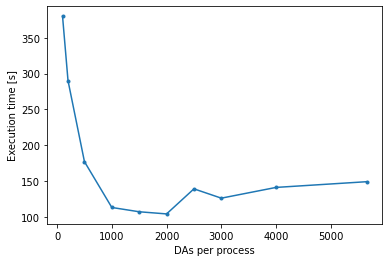

In [48]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

timing = [(5659,149,10),(4000,141,15),(3000,126,19),(2500,139,23),(2000,104,29),(1500,107,38),(1000,113,57),(500,177,114),(200,290,283),(100,380,566)] # (DIV,time)
timing = [(11318,,5),(5659,,10),(4000,,15),(3000,100,19),(2500,,23),(2000,92,29),(1500,,38),(1000,94,57),(500,,114),(200,,283),(100,,566)] # (DIV,time)
x, y, z = zip(*timing)
plt.plot(x,y,'.-')
plt.xlabel('DAs per process')
plt.ylabel('Execution time [s]')
# 200 failed... index 163 for 100... why!? Had to fix update of Part 2 to iloc from loc for case of single-True indb_cut (single True returned a series, not a DF, I think that was the trouble... loc indexing by boolean array can't coerce a DF return... unless ,:]['col'] were used perhaps, but even then just a series would be returned of col values for the row...)

In [ ]:
gdf_joined.shape

In [50]:
import shapely
shapely.ops.unary_union(gdf_joined.geometry)

TopologyException: found non-noded intersection between LINESTRING (5.27866e+06 1.63999e+06, 5.27866e+06 1.63999e+06) and LINESTRING (5.27866e+06 1.64e+06, 5.27866e+06 1.63999e+06) at 5278655.732898212 1639987.9225103096


ValueError: No Shapely geometry can be created from null value

In [57]:
int('str')

ValueError: invalid literal for int() with base 10: 'str'

In [55]:
import multiprocess
import OverlapDevelopmentMP
import time
import ipypb # Lightweight progress bar, source copied from GitHub
import geopandas
import pandas as pd
import importlib
importlib.reload(OverlapDevelopmentMP)

def intersectGDFMP(gdf1, keyfield1, gdf2, keyfield2, areas_in=None, verbosity=1, area_epsg=6931, apply_buffer=False, threshold=None, vertex_limit=10000, check_inputs=True, num_process=None, num_block=None):
    '''Multiprocess overlap between geometries in two geodataframes
    
    TODO:
    Verbosity comments in input checks
    Documentation
    Separate multiprocess sections for: input checking, geometry cutting, overlap calculation
    '''

    # Multiprocessing code:
    if __name__ == '__main__':
        
        if verbosity>=1: print('Executing intersectGDFMP')
        begin_time = time.time()
        
        # Input checks
        NCPU = multiprocess.cpu_count()
        N2 = gdf2.shape[0]
        
        if check_inputs:
            if num_process is None:
                num_process = max(1, NCPU-2) # empirical factor for circa 2020 multicore computers, prevents lockup by leaving processes available for the system and other applications
            else:
                try:
                    num_process = int(num_process)
                except (ValueError, TypeError):
                    print(f'Input Error: num_process must be an integer (there are {NCPU} CPUs detected, input was: {num_process})')
                    return None
                if num_process < 0:
                    tmp = num_process
                    num_process = max(1, NCPU-num_process)
                else:
                    num_process = min(NCPU, num_process)
            if verbosity>=1: print(f'  num_process set to {num_process} (of {NCPU})')

            if num_block is None:
                num_block = N2
                if num_process>1:
                    num_block = max(1,num_block//(3*num_process)) # empirical factor based on Canadian census CFSA and DA catographic geometry overlap calculation
            else:
                try:
                    num_block = int(num_block)
                except (ValueError, TypeError):
                    print(f'Input Error: num_block must be an integer (input was: {num_block})')
                    return None
                num_block = max(1,min(num_block,N2))
            if verbosity>=1: print(f'  num_block set to {num_block} (of {N2})')
                
            # Ensure coordinate reference systems match
            if gdf1.crs!=gdf2.crs:
                print(f"Input coordinate reference systems must be the same: gdf1.crs={gdf1.crs}, gdf2.crs={gdf2.crs}")
                return None

            # Ensure geometries are valid
            n_invalid1 = gdf1.shape[0]-sum(gdf1.geometry.is_valid)
            n_invalid2 = gdf2.shape[0]-sum(gdf2.geometry.is_valid)
            if not apply_buffer and (n_invalid1>0 or n_invalid2>0):
                print(f"Input geometries must be valid: {n_invalid1} invalid geometries in gdf1, {n_invalid2} invalid geometries in gdf2")
                return None

            # Ensure areas_in is the proper size
            if not areas_in is None:
                N2 = len(areas_in)
                if N2!=gdf2.shape[0]:
                    print(f"Input areas_in must have length {gdf2.shape[0]}, actual length is {N2}")
                    return None
                N1 = len(areas_in[0])
                irreg = not all([len(a)==N1 for a in areas_in])
                if len(areas_in)!=gdf2.shape[0] or N1!=gdf1.shape[0] or irreg:
                    print(f"Input areas_in must have size [{gdf2.shape[0]}][{gdf1.shape[0]}], actual shape is [{N2}][{N1}]{' with irregular second dimension length' if irreg else ''}")
                    return None

            # Checks performed here, no need to do so in intersectGDF
            check_inputs = False 
        
        NDIV = N2//num_block+(0 if N2%num_block==0 else 1)
        results = [None]*NDIV

        start_time = time.time()
        completed = 0
        with multiprocess.Pool(num_process) as pool:
            print(f'Generating pool, P={num_process}, N={N2}, DIV={num_block}, NDIV={NDIV}')
            ret = [pool.apply_async(OverlapDevelopmentMP.intersectGDF,(gdf1,key1,gdf2.iloc[ind*num_block:((ind+1)*num_block if (ind+1)*num_block<N2 else N2),:],key2,areas_in if areas_in is None else areas_in[ind*num_block:((ind+1)*num_block if (ind+1)*num_block<N2 else N2)],verbosity,area_epsg,apply_buffer,threshold,vertex_limit,check_inputs)) for ind in range(NDIV)]
            print('Processing pool')
            for i in ipypb.track(range(NDIV)): # Alternative: initialize pb and call next(pb) in loop, instead of having a while loop to process all updates since last loop
                while True:
                    indb_finished = [r.ready() for r in ret]
                    indb_empty = [r is None for r in results]
                    indb_update = [f and e for f, e in zip(indb_finished, indb_empty)]
                    if any(indb_update):
                        ind_update = indb_update.index(True)
                        results[ind_update] = ret[ind_update].get(999) # Set finite timeout so that it returns properly
                        completed += 1
                        if completed%10==0 or completed==1 or completed==(NDIV):
                            print(f'Finished {completed}/{NDIV}, wall time {time.strftime("%H:%M:%S", time.gmtime(time.time()-start_time))}')
                        break
                    time.sleep(1) # Make the infinite loop run slower; might be improved with explicit async

        wall_time = time.time()-start_time
        processor_time = sum([r[1] for r in results])
        gdf_joined = pd.concat([r[0] for r in results]).sort_values(keyfield2,ignore_index=True)
        print(f'Pool processing concluded, process count {sum([r!=None for r in results])}/{NDIV}, wall time {time.strftime("%H:%M:%S", time.gmtime(wall_time))}, processor time {time.strftime("%H:%M:%S", time.gmtime(processor_time))}, processor:wall ratio {processor_time/wall_time:.3}x')
        print(f'Total time: {time.strftime("%H:%M:%S", time.gmtime(time.time()-begin_time))}')
        return gdf_joined
    return None

In [60]:
help(loadResults_)

Help on function loadResults_ in module __main__:

loadResults_(name, tuples, fileformat='db', compress=False)
    Loads variables from files
    
    Parameters
    ----------
    name: str, file name base (including directory if desired)
    tuples: list of tuples (varname, suffix),
        varname: str, the key of the output dict where the data will be stored
        suffix: str, the string appended to name to generate a full file name
    fileformat: str, suffix to save the file with (do not include period)
    compress: bool, True to zip results (appends '.gz' to filename)
    
    Returns
    -------
    None if an error was encountered, or
    Tuple the length of tuples containing for each element of tuples:
        None if there was an error, or
        the variable loaded from file at the same position from tuples
    
    Notes
    -----
    Files read in binary format with optional gzip encoding
    This function is the complement to saveResults_()
    
    TODO
    ----
   

In [97]:
import numpy as np

def normalizeRows(areas, aslist=False):
    '''Normalizes each row of the input by its sum (numpy.array)'''
    a = np.array(areas)
    a = a / np.sum(a,axis=1)[:, np.newaxis]
    return a.tolist() if aslist else a

def thresholdAreas(areas, threshold=1e-6, aslist=False):
    '''Zeros out elements of areas that are below the threshold (numpy.array(float))'''
    a = np.array(areas)
    a_ratio = normalizeRows(areas)
    a[a_ratio<threshold] = 0
    return a.tolist() if aslist else a

def normalizeAreas(areas, threshold=1e-6, aslist=False):
    '''Thresholds then normalizes areas (numpy.array(float))'''
    a = thresholdAreas(areas, threshold)
    a = normalizeRows(a)
    return a.tolist() if aslist else a

def maximumAreas(areas, aslist=False):
    '''Zeros out non-maximum elements in each row of areas (numpy.array(int))
    Test with e.g.: (max(np.sum(r,axis=1)), min(np.sum(r,axis=1)), np.sum(r))'''
    a = np.array(areas)
    a_max = np.max(a,axis=1)
    r = (a >= a_max[:,np.newaxis]).astype(int)
    return r.tolist() if aslist else r

In [113]:
DIR_DATA = 'Data/'
DIR_RESULTS = 'Results/'
# <Copy of GMLtoGDF()>
# <Copy of file loading for gdf_CA_*>
import dill
import gzip
a = loadResults_(DIR_RESULTS+'GDF_FSA-DA_D_M2AREA',[('a','_areas'),],compress=True)[0]
# areas_arr = [None, a, normalizeAreas(a,threshold=threshold,aslist=True),maximumAreas(a,aslist=True)]
#a = None
#a = a#[aa.tolist() for aa in a]
a = normalizeAreas(a,threshold=1e-6,aslist=True)
#a = maximumAreas(a,aslist=True)

gdf1 = gdf_CA_FSA_Db
key1 = 'CFSAUID'
gdf2 = gdf_CA_DA_Db
key2 = 'DAUID'
areas_in=np.array(a) if not a is None else a
verbosity=1
area_epsg=6931
apply_buffer=False
threshold=None
vertex_limit=10000
check_inputs=True
num_process=10
num_block=2000

Singular Areas

In [108]:
%%time
importlib.reload(OverlapDevelopmentMP)
gdfjmp = intersectGDFMP(gdf1, key1, gdf2, key2, areas_in, verbosity, area_epsg, apply_buffer, threshold, vertex_limit, check_inputs, num_process, num_block)

Executing intersectGDFMP
  num_process set to 10 (of 12)
  num_block set to 2000 (of 56590)
Generating pool, P=10, N=56590, DIV=2000, NDIV=29
Processing pool


 [████████████████████████████████████████████████████████████] 29/29 [01:01<00:03, 2.09s/it]

Finished 1/29, wall time 00:00:12
Finished 10/29, wall time 00:00:21
Finished 20/29, wall time 00:00:40
Finished 29/29, wall time 00:01:00
Pool processing concluded, process count 29/29, wall time 00:01:01, processor time 00:04:14, processor:wall ratio 4.17x
Total time: 00:01:05
Wall time: 1min 6s


Threshold Areas

In [101]:
%%time
importlib.reload(OverlapDevelopmentMP)
gdfjmp = intersectGDFMP(gdf1, key1, gdf2, key2, areas_in, verbosity, area_epsg, apply_buffer, threshold, vertex_limit, check_inputs, num_process, num_block)

Executing intersectGDFMP
  num_process set to 10 (of 12)
  num_block set to 2000 (of 56590)
Generating pool, P=10, N=56590, DIV=2000, NDIV=29
Processing pool


 [████████████████████████████████████████████████████████████] 29/29 [03:36<00:08, 7.46s/it]

Finished 1/29, wall time 00:00:19
Finished 10/29, wall time 00:01:15
Finished 20/29, wall time 00:02:32
Finished 29/29, wall time 00:03:36
Pool processing concluded, process count 29/29, wall time 00:03:36, processor time 00:02:49, processor:wall ratio 0.781x
Total time: 00:03:39
Wall time: 3min 39s


Areas Shortcut

In [112]:
%%time
importlib.reload(OverlapDevelopmentMP)
gdfjmp = intersectGDFMP(gdf1, key1, gdf2, key2, areas_in, verbosity, area_epsg, apply_buffer, threshold, vertex_limit, check_inputs, num_process, num_block)

Executing intersectGDFMP
  num_process set to 10 (of 12)
  num_block set to 2000 (of 56590)
Generating pool, P=10, N=56590, DIV=2000, NDIV=29
Processing pool


 [████████████████████████████████████████████████████████████] 29/29 [01:36<00:13, 3.32s/it]

Finished 1/29, wall time 00:00:15
Finished 10/29, wall time 00:00:26
Finished 20/29, wall time 00:00:50
Finished 29/29, wall time 00:01:36
Pool processing concluded, process count 29/29, wall time 00:01:36, processor time 00:08:04, processor:wall ratio 5.02x
Total time: 00:01:40
Wall time: 1min 40s


All Overlaps

Digital all overlap calculation:

In [110]:
%%time
importlib.reload(OverlapDevelopmentMP)
gdfjmp = intersectGDFMP(gdf1, key1, gdf2, key2, areas_in, verbosity, area_epsg, apply_buffer, threshold, vertex_limit, check_inputs, num_process, num_block)

Executing intersectGDFMP
  num_process set to 10 (of 12)
  num_block set to 2000 (of 56590)
Generating pool, P=10, N=56590, DIV=2000, NDIV=29
Processing pool


 [████████████████████████████████████████████████████████████] 29/29 [01:38<00:07, 3.38s/it]

Finished 1/29, wall time 00:00:14
Finished 10/29, wall time 00:00:25
Finished 20/29, wall time 00:00:45
Finished 29/29, wall time 00:01:38
Pool processing concluded, process count 29/29, wall time 00:01:38, processor time 00:08:24, processor:wall ratio 5.13x
Total time: 00:01:41
Wall time: 1min 41s


In [59]:
%%time
importlib.reload(OverlapDevelopmentMP)
gdfjmp = intersectGDFMP(gdf1, key1, gdf2, key2, areas_in, verbosity, area_epsg, apply_buffer, threshold, vertex_limit, check_inputs, num_process, num_block)

Executing intersectGDFMP
  num_process set to 10 (of 12)
  num_block set to 2000 (of 56590)
Generating pool, P=10, N=56590, DIV=2000, NDIV=29
Processing pool


 [████████████████████████████████████████████████████████████] 29/29 [02:38<00:08, 5.46s/it]

Finished 1/29, wall time 00:00:29
Finished 10/29, wall time 00:00:50
Finished 20/29, wall time 00:01:18
Finished 29/29, wall time 00:02:38
Pool processing concluded, process count 29/29, wall time 00:02:38, processor time 00:14:36, processor:wall ratio 5.53x
Total time: 00:02:42
Wall time: 2min 42s


Cartographic all overlap calculation:

In [57]:
%%time
importlib.reload(OverlapDevelopmentMP)
gdfjmp = intersectGDFMP(gdf1, key1, gdf2, key2, areas_in, verbosity, area_epsg, apply_buffer, threshold, vertex_limit, check_inputs, num_process, num_block)

Executing intersectGDFMP
  num_process set to 10 (of 12)
  num_block set to 2000 (of 56589)
Generating pool, P=10, N=56589, DIV=2000, NDIV=29
Processing pool


 [████████████████████████████████████████████████████████████] 29/29 [10:57<02:29, 22.64s/it]

Finished 1/29, wall time 00:00:55
Finished 10/29, wall time 00:02:17
Finished 20/29, wall time 00:05:14
Finished 29/29, wall time 00:10:56
Pool processing concluded, process count 29/29, wall time 00:10:56, processor time 01:01:27, processor:wall ratio 5.61x
Total time: 00:14:36
Wall time: 14min 36s


In [48]:
print(all(gdfjmp.geometry.is_valid))
print(any(gdfjmp.geometry.is_empty))
print(set([g.type for g in gdfjmp.geometry]))

True
False
{'MultiPolygon', 'Polygon'}


In [78]:
ff = [g.type for g in gdfjmp.geometry]
print(set(ff))

{'Polygon', 'Point', 'MultiPolygon', 'MultiLineString', 'LineString', 'MultiPoint', 'GeometryCollection'}


In [80]:
gdfjmp.loc[gdfjmp.geometry.type == 'Point']

,CFSAUID Index,CFSAUID,DAUID Index,DAUID,Overlap Geometry,Overlap Area,DAUID Overlap Ratio
59271,1311,S7N,39551,47110096,POINT (5209323.974 1889727.134),0.0,0.0
59290,1506,S7H,42356,47110106,POINT (5209515.229 1890520.763),0.0,0.0
59302,1387,S7V,42366,47110123,POINT (5212281.283 1888228.846),0.0,0.0
59317,1338,S7T,42327,47110144,POINT (5211298.769 1885483.363),0.0,0.0
59357,1573,S7J,39511,47110182,POINT (5206008.174 1888980.263),0.0,0.0
59358,1602,S7M,39511,47110182,POINT (5206076.803 1889274.166),0.0,0.0
59361,1311,S7N,39513,47110184,POINT (5206920.663 1889603.340),0.0,0.0
59375,1338,S7T,39518,47110189,POINT (5205281.429 1888284.266),0.0,0.0
59380,1338,S7T,39567,47110191,POINT (5204868.966 1888385.220),0.0,0.0
59400,1337,S7S,40179,47110302,POINT (5212427.029 1891792.891),0.0,0.0


In [81]:
gdfjmp.loc[gdfjmp.geometry.type == 'MultiLineString']

,CFSAUID Index,CFSAUID,DAUID Index,DAUID,Overlap Geometry,Overlap Area,DAUID Overlap Ratio
606,23,A0A,446,10010768,"MULTILINESTRING ((8965891.223 2153384.774, 896...",0.0,0.0
980,53,A2H,712,10050122,"MULTILINESTRING ((8562967.151 2053779.511, 856...",0.0,0.0
1072,28,A0H,678,10060086,"MULTILINESTRING ((8672438.526 2131270.311, 867...",0.0,0.0
1443,130,G0G,1275,10100082,"MULTILINESTRING ((7697173.954 2381076.483, 769...",0.0,0.0
2195,113,B4V,1553,12060115,"MULTILINESTRING ((8369599.477 1385635.097, 836...",0.0,0.0
...,...,...,...,...,...,...,...
79252,1275,V0L,55657,59410408,"MULTILINESTRING ((4332752.677 2201806.443, 432...",0.0,0.0
79851,1456,V2N,56415,59530170,"MULTILINESTRING ((4278577.809 2445799.411, 427...",0.0,0.0
80145,1409,T0E,55448,59550231,"MULTILINESTRING ((4434853.954 2356080.031, 443...",0.0,0.0
80372,1360,X0C,56400,61060141,"MULTILINESTRING ((5696684.517 2950665.151, 569...",0.0,0.0


In [84]:
gdfjmp.loc[gdfjmp.geometry.type == 'LineString']

,CFSAUID Index,CFSAUID,DAUID Index,DAUID,Overlap Geometry,Overlap Area,DAUID Overlap Ratio
53958,1069,P7K,37845,35580440,"LINESTRING (6389459.751 1360031.349, 6389459.7...",0.0,0.0
54953,1088,R0J,40153,46070185,"LINESTRING (5626123.166 1583487.997, 5626123.1...",0.0,0.0
56710,1250,R3C,40648,46111220,"LINESTRING (5820425.443 1553151.760, 5820425.4...",0.0,0.0
56778,1140,R3X,40921,46120066,"LINESTRING (5830388.889 1537236.243, 5830276.0...",0.0,0.0
59232,1574,S7K,40175,47110075,"LINESTRING (5206272.751 1890410.766, 5206201.5...",0.0,0.0
59254,1311,S7N,39500,47110084,"LINESTRING (5207493.697 1889590.329, 5207310.7...",0.0,0.0
59276,1311,S7N,39553,47110098,"LINESTRING (5208633.457 1889890.237, 5208531.9...",0.0,0.0
59431,1337,S7S,42918,47110328,"LINESTRING (5213078.369 1891608.480, 5212937.8...",0.0,0.0
59435,1388,S7W,42921,47110331,"LINESTRING (5214003.646 1890747.889, 5213839.8...",0.0,0.0
59483,1336,S7R,43127,47110377,"LINESTRING (5204218.086 1893784.463, 5204134.1...",0.0,0.0


In [85]:
gdfjmp.loc[gdfjmp.geometry.type == 'MultiPoint']

,CFSAUID Index,CFSAUID,DAUID Index,DAUID,Overlap Geometry,Overlap Area,DAUID Overlap Ratio
59340,1338,S7T,42381,47110164,"MULTIPOINT (5208327.934 1886747.749, 5208502.4...",0.0,0.0
59359,1573,S7J,39512,47110183,"MULTIPOINT (5206802.609 1888682.709, 5207071.0...",0.0,0.0
59456,1602,S7M,42937,47110356,"MULTIPOINT (5201308.489 1894366.763, 5201389.3...",0.0,0.0
59664,1338,S7T,39641,47110535,"MULTIPOINT (5206976.617 1887290.220, 5207081.9...",0.0,0.0
59675,1574,S7K,39646,47110540,"MULTIPOINT (5202298.206 1887556.863, 5202995.2...",0.0,0.0
64587,1428,T4N,46208,48080079,"MULTIPOINT (4749904.274 2041492.011, 4749905.7...",0.0,0.0
65105,1431,T4S,46730,48080530,"MULTIPOINT (4738800.346 2032121.123, 4739074.0...",0.0,0.0


In [86]:
gdfjmp.loc[gdfjmp.geometry.type == 'GeometryCollection']

,CFSAUID Index,CFSAUID,DAUID Index,DAUID,Overlap Geometry,Overlap Area,DAUID Overlap Ratio
1013,30,A0K,630,10050151,GEOMETRYCOLLECTION (LINESTRING (8608976.289 21...,0.039269,1.360727e-11
1019,57,A8A,631,10050152,GEOMETRYCOLLECTION (LINESTRING (8608976.251 21...,0.010022,4.840759e-10
1130,57,A8A,797,10060125,GEOMETRYCOLLECTION (POINT (8635357.980 2101389...,0.068484,1.155469e-11
1466,34,A0P,1312,10100102,GEOMETRYCOLLECTION (POINT (8442282.917 2401832...,0.029083,6.165925e-13
1473,34,A0P,1318,10100108,GEOMETRYCOLLECTION (LINESTRING (8442282.917 24...,0.000622,1.048195e-13
...,...,...,...,...,...,...,...
80273,1365,Y0B,56465,60010276,GEOMETRYCOLLECTION (LINESTRING (4142358.903 36...,0.140307,8.672255e-13
80413,495,J0M,56342,62040059,GEOMETRYCOLLECTION (LINESTRING (7032890.766 21...,0.964554,3.018265e-13
80415,1151,P0L,56342,62040059,GEOMETRYCOLLECTION (POINT (6909747.051 1830464...,0.002294,7.177247e-16
80417,504,J0Y,56342,62040059,GEOMETRYCOLLECTION (LINESTRING (7090971.474 18...,0.088782,2.778152e-14


In [90]:
tmp = gdfjmp.geometry.loc[1013]

GEOMETRYCOLLECTION (LINESTRING (8608976.28856956 2120414.85143072, 8608976.251407258 2120414.912336125), POLYGON ((8627478.494284412 2139990.162854498, 8627030.202855 2139607.8, 8625975.077145001 2138950.83143, 8624209.9 2137371.462855, 8623333.945715001 2136827.31143, 8622795.062855 2136701.76857, 8622763.248570001 2136694.59143, 8622748.937145 2136687.23143, 8621124.154285001 2135851.817145, 8619704.04857 2135121.857145, 8618461.66 2134846.482855, 8617340.205715001 2134597.91143, 8617129.279999999 2134551.16, 8615825.53143 2134298.434285, 8615602.4 2134255.18, 8614972.574285001 2134133.09143, 8613367.497145001 2134198.037145, 8612676.517145 2134225.994285, 8612669.845714999 2134231.56, 8611812.977144999 2133149.52, 8611188.677145001 2132403.22857, 8610175.502854999 2132052.00857, 8610001.39143 2131785.034285, 8607941.728569999 2131927.46, 8607819.18 2131935.934285, 8607796.622855 2131937.24857, 8607643.488569999 2131906.277145, 8607170.414285 2131595.234285, 8607111.062855 2131556.21

In [91]:
len(tmp)

65

In [94]:
fff = [g.type for g in tmp]
set(fff)

{'LineString', 'Polygon'}

In [106]:
x = [[g.type for g in r] for r in gdfjmp.loc[gdfjmp.geometry.type == 'GeometryCollection'].geometry]
y = [set(v) for v in x]
z = set()
for yy in y:
    z = z.union(yy)
z

{'LineString', 'Point', 'Polygon'}

So only simple geometries are included in the GeometryCollection.  We can go through and select only Polygons and then make a MultiPolygon from them (if there is more than one)

In [ ]:
glist = [g for g in geom if g.type=='Polygon']
shapely.geometry.multipolygon.MultiPolygon([])

In [109]:
gdfjmp.loc[gdfjmp.geometry.type == 'GeometryCollection']['DAUID Overlap Ratio'].sort_values()

59674    0.0
65106    0.0
59057    0.0
59062    0.0
59080    0.0
        ... 
67963    1.0
61420    1.0
55015    1.0
58502    1.0
67183    1.0
Name: DAUID Overlap Ratio, Length: 368, dtype: float64

In [206]:
def cleanGeometry(geom):
    '''Coerces geometry into a Polygon or MultiPolygon
    
    Selects only components of input shapely geometry that are non-empty
    Polygons or MultiPolygons and returns:
        an empty GeometryCollection if there are no selected elements
        the non-empty element if there is one selected element
        a multipolygon if there are multiple selected elements
    
    Requires shapely
    TODO: add case of nested GeometryCollections
    '''
    if geom.is_empty:
        return shapely.geometry.Polygon([])
    if geom.type in {'Polygon','MultiPolygon'}:
        return geom
    if not geom.type in {'GeometryCollection'}:
        return shapely.geometry.Polygon([])
    # A GeometryCollection contains only Points, LineStrings, or Polygons...
    print('selecting only polygons')
    polys = [g for g in list(geom) if g.type in {'Polygon','MultiPolygon'} and not g.is_empty]
    if len(polys)==0:
        return shapely.geometry.Polygon([])
    elif len(polys)==1:
        return polys[0]
    else:
        polys = [g if g.type=='Polygon' else list(g) for g in polys]
        return shapely.geometry.MultiPolygon(polys)
    return None # This should never be reached

In [120]:
print(shapely.geometry.Polygon([]))

GEOMETRYCOLLECTION EMPTY


In [129]:
x = shapely.geometry.Polygon([])
print(x)
x.is_empty

GEOMETRYCOLLECTION EMPTY


True

In [137]:
print(cleanGeometry(shapely.geometry.Polygon([])))

GEOMETRYCOLLECTION EMPTY


In [208]:
geom = gdfjmp.loc[gdfjmp.geometry.type == 'MultiPoint'].geometry.iloc[6]
geom = cleanGeometry(geom)
print(geom.is_valid)
print(geom.type)
print(len(geom) if not geom.type=='Polygon' and not geom.is_empty else 0 if geom.is_empty else 1)

True
GeometryCollection
0


In [160]:
geom.area

0.027078864280685906

In [198]:
x = shapely.geometry.GeometryCollection([shapely.geometry.Point(1,1),shapely.geometry.LineString([]),shapely.geometry.MultiPolygon([shapely.geometry.Polygon([[1,1],[2,2],[1,2],[1,1]])])])

In [199]:
list(x)

In [200]:
x.is_empty

False

In [201]:
[y.is_empty for y in x]

[False, True, False]

In [209]:
print(cleanGeometry(x))

selecting only polygons
MULTIPOLYGON (((1 1, 2 2, 1 2, 1 1)))


In [205]:
x.count

AttributeError: 'GeometryCollection' object has no attribute 'count'